<a href="https://colab.research.google.com/github/kuds/rl-mujoco-tennis/blob/main/%5BMuJoCo%20Paddle%5D%20Soft%20Actor-Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MuJoCo Paddle

https://github.com/denisgriaznov/CustomMuJoCoEnviromentForRL

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [2]:
!pip install stable-baselines3

In [3]:
import gymnasium
import mujoco
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_vec_env
import numpy
import os
import torch
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot
from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import SAC

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Mujoco Version: {version('mujoco')}")
print(f"Stable-Baselines3 Version: {version('stable-baselines3')}")
print(f"Matplotlib Version: {version('matplotlib')}")

Python Version: 3.11.11
Torch Version: 2.5.1+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Mujoco Version: 3.3.0
Stable-Baselines3 Version: 2.5.0
Matplotlib Version: 3.10.0


In [5]:
rl_type = "SAC"
env_str = "BallBalance"
log_dir = "./logs/{}".format(env_str)
name_prefix = "ball_balance"

In [6]:
class BallBalanceEnv(MujocoEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 100,
    }

    # set default episode_len for truncate episodes
    def __init__(self, episode_len=750, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)
        # change shape of observation to your observation space size
        observation_space = Box(low=-numpy.inf, high=np.inf, shape=(18,), dtype=numpy.float64)
        # load your MJCF model with env and choose frames count between actions
        MujocoEnv.__init__(
            self,
            os.path.abspath("/content/ball_balance.xml"),
            5,
            observation_space=observation_space,
            **kwargs
        )
        self.step_number = 0
        self.episode_len = episode_len

    # determine the reward depending on observation or other properties of the simulation
    def step(self, a):
        reward = 1.0
        self.do_simulation(a, self.frame_skip)
        self.step_number += 1

        obs = self._get_obs()
        done = bool(not np.isfinite(obs).all() or (obs[2] < 0))
        truncated = self.step_number > self.episode_len
        return obs, reward, done, truncated, {}

    # define what should happen when the model is reset (at the beginning of each episode)
    def reset_model(self):
        self.step_number = 0

        # for example, noise is added to positions and velocities
        qpos = self.init_qpos + self.np_random.uniform(
            size=self.model.nq, low=-0.01, high=0.01
        )
        qvel = self.init_qvel + self.np_random.uniform(
            size=self.model.nv, low=-0.01, high=0.01
        )
        self.set_state(qpos, qvel)
        return self._get_obs()

    # determine what should be added to the observation
    # for example, the velocities and positions of various joints can be obtained through their names, as stated here
    def _get_obs(self):
        obs = np.concatenate((np.array(self.data.joint("ball").qpos[:3]),
                              np.array(self.data.joint("ball").qvel[:3]),
                              np.array(self.data.joint("rotate_x").qpos),
                              np.array(self.data.joint("rotate_x").qvel),
                              np.array(self.data.joint("rotate_y").qpos),
                              np.array(self.data.joint("rotate_y").qvel),
                              np.array(self.data.joint("rotate_z").qpos),
                              np.array(self.data.joint("rotate_z").qvel),
                              np.array(self.data.joint("slider_x").qpos),
                              np.array(self.data.joint("slider_x").qvel),
                              np.array(self.data.joint("slider_y").qpos),
                              np.array(self.data.joint("slider_y").qvel),
                              np.array(self.data.joint("slider_z").qpos),
                              np.array(self.data.joint("slider_z").qvel)), axis=0)
        return obs

In [7]:
# Ensure environment XML (MuJoCo model) is available
xml_content = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>
    <body name="box" pos=".2 .2 .1">
      <joint name="rotate_x" pos="0 0 0" axis="1 0 0" range="-.25 .25" damping="20" />
      <joint name="rotate_y" pos="0 0 0" axis="0 1 0" range="-.25 .25" damping="20" />
			<joint name="rotate_z" pos="0 0 0" axis="0 0 1" range="-.25 .25" damping="20" />
			<joint axis="0 0 1" limited="true" name="slider_z" range="0 1" type="slide"/>
			<joint axis="0 1 0" limited="true" name="slider_y" range="-.25 .25" type="slide"/>
			<joint axis="1 0 0" limited="true" name="slider_x" range="-.25 .25" type="slide"/>
      <geom name="box" type="box" size=".2 .2 .02" rgba="1 0 0 1"/>
    </body>
    <body name="ball" pos=".2 .2 .4">
      <freejoint name="ball"/>
      <geom name="ball" pos="0 0 0" size=".05" rgba="0 1 0 1"/>
    </body>
  </worldbody>
  <actuator>
    <general name="act_x" joint="rotate_x" ctrlrange="-1 1" gainprm="1000 0 0" />
    <general name="act_y" joint="rotate_y" ctrlrange="-1 1" gainprm="1000 0 0" />
		<general name="act_z" joint="rotate_z" ctrlrange="-1 1" gainprm="1000 0 0" />
    <motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="slider_z" name="slider_z"/>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="slider_y" name="slider_y"/>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="slider_x" name="slider_x"/>
  </actuator>
</mujoco>
"""

with open("ball_balance.xml", "w") as f:
    f.write(xml_content)

In [8]:
env = BallBalanceEnv(render_mode="rgb_array")
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (18,)
Actions Space:  Box(-1.0, 1.0, (6,), float32)


In [9]:
def make_env():
  env = BallBalanceEnv(render_mode="rgb_array")
  check_env(env)
  return env

# Create Training environment
env = make_vec_env(make_env, n_envs=4)

# Create Evaluation environment
env_val = make_vec_env(make_env, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             render=False,
                             deterministic=True,
                             eval_freq=50_000)

# learning with tensorboard logging and saving model
model = SAC("MlpPolicy",
            env,
            verbose=0,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

model.learn(total_timesteps=2_000_000,
            log_interval=4,
            callback=eval_callback,
            progress_bar=True)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=200000, episode_reward=120.60 +/- 13.63

Episode length: 120.60 +/- 13.63

New best mean reward!

Eval num_timesteps=400000, episode_reward=178.60 +/- 22.72

Episode length: 178.60 +/- 22.72

New best mean reward!

Eval num_timesteps=600000, episode_reward=692.80 +/- 86.15

Episode length: 692.80 +/- 86.15

New best mean reward!

Eval num_timesteps=800000, episode_reward=751.00 +/- 0.00

Episode length: 751.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1000000, episode_reward=669.40 +/- 43.49

Episode length: 669.40 +/- 43.49

Eval num_timesteps=1200000, episode_reward=751.00 +/- 0.00

Episode length: 751.00 +/- 0.00

Eval num_timesteps=1400000, episode_reward=422.20 +/- 129.22

Episode length: 422.20 +/- 129.22

Eval num_timesteps=1600000, episode_reward=751.00 +/- 0.00

Episode length: 751.00 +/- 0.00

Eval num_timesteps=1800000, episode_reward=751.00 +/- 0.00

Episode length: 751.00 +/- 0.00

Eval num_timesteps=2000000, episode_reward=672.00 +/- 96.90

Episode length: 672.00 +/- 96.90

Mean reward: 728.50 +/- 67.50


In [10]:
# Create Evaluation environment
env = BallBalanceEnv(render_mode="rgb_array")
check_env(env)
env = DummyVecEnv([lambda: env])

# Load the best model
best_model_path = os.path.join(log_dir, "best_model")
best_model = SAC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model
env = VecVideoRecorder(env, os.path.join(log_dir, "videos"),
                       video_length=10_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_{}".format(name_prefix))

obs = env.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Best Model - Mean reward: 751.00 +/- 0.00


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/logs/BallBalance/videos/best_model_ball_balance-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBalance/videos/best_model_ball_balance-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBalance/videos/best_model_ball_balance-step-0-to-step-10000.mp4


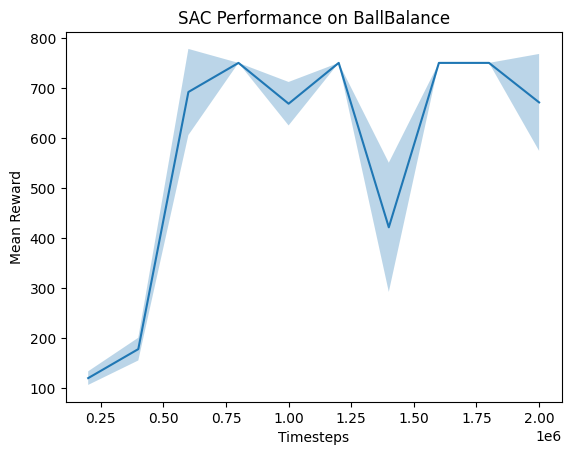

In [11]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()